<a href="https://colab.research.google.com/github/DangDuyAnh/CreditRisk_MachineLearning/blob/main/Credit_Risk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import libraries

In [ ]:
import pandas as pd
import numpy as np

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score #To evaluate our model


# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns

# File system manangement
import os

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.metrics import recall_score
from scipy import stats 
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.decomposition import PCA
import warnings

import itertools

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import xgboost as xgb
from sklearn.model_selection import GridSearchCV

from sklearn.impute import SimpleImputer

# Memory management
import gc 
from joblib import dump
from joblib import load

import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.optimizers import SGD

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import roc_auc_score

from keras.callbacks import ModelCheckpoint
from keras.models import load_model

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# 2. Functions

In [ ]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [ ]:
#Function to plot confusion matrix
#------------------------------------------------------------------------------------------------------------------------------
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    #Add Normalization Option
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
#Plot Feature inportance
#---------------------------------------------------------------------------------------
def plot_feature_importances(model,X_train):
    
    xaxes=list(X_train.columns.values)
    yaxes=list(model.feature_importances_)
    
    h=dict(zip(xaxes,yaxes))
    s = [(k, h[k]) for k in sorted(h, key=h.get, reverse=False)]
    s=dict(s)
    xaxes=list(s.keys())
    yaxes=list(s.values())
    
    xaxes = xaxes[-30:]
    yaxes = yaxes[-30:] 
    n_features = 30
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), yaxes, align='center') 
    plt.yticks(np.arange(n_features), xaxes) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    print(xaxes)
    print(yaxes)
   

In [ ]:
def rocurve(logreg, X_train, X_test, y_train, y_test):
    
    from sklearn.metrics import roc_curve, auc
    import matplotlib.pyplot as plt
    import seaborn as sns
    %matplotlib inline
    
    y_test_score = logreg.decision_function(X_test)
    y_train_score = logreg.decision_function(X_train)

    test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_score)
    train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_score)

    print('Test AUC: {}'.format(auc(test_fpr, test_tpr)))
    print('train AUC: {}'.format(auc(train_fpr, train_tpr)))

    plt.figure(figsize=(10,8))
    lw = 2
    plt.plot(test_fpr, test_tpr, color='darkorange',
             lw=lw, label='Test ROC curve')
    plt.plot(train_fpr, train_tpr, color='blue',
             lw=lw, label='train ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
def agg_numeric(df, group_var, df_name):
    # Remove id variables other than grouping variable
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    group_ids = df[group_var]
    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = group_ids

    # Group by the specified variable and calculate the statistics
    # agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()
    agg = numeric_df.groupby(group_var).agg(['mean', 'max', 'min', 'sum']).reset_index()

    # Need to create new column names
    columns = [group_var]

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        # Skip the grouping variable
        if var != group_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1][:-1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))

    agg.columns = columns
    return agg

In [ ]:
def count_categorical(df, group_var, df_name):
    
    # Select the categorical columns
    categorical = pd.get_dummies(df.select_dtypes('object'))

    # Make sure to put the identifying id on the column
    categorical[group_var] = df[group_var]

    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(group_var).agg(['sum', 'mean'])
    
    column_names = []
    
    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['count', 'count_norm']:
            # Make a new column name
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    
    return categorical

# 3. Preprocessing data

## 3.1 Table: Application_train

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Credit Risk/Data/home_credit/application_train.csv')
print(data.shape)
data.head()

(307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
data.TARGET.value_counts() # số lượng nhãn hiện có

0    282686
1     24825
Name: TARGET, dtype: int64

In [ ]:
useless_columns = ['NAME_TYPE_SUITE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE',
'FLAG_WORK_PHONE' , 'FLAG_CONT_MOBILE' , 'FLAG_PHONE' , 'FLAG_EMAIL' , 'WEEKDAY_APPR_PROCESS_START',
'HOUR_APPR_PROCESS_START' , 'REG_REGION_NOT_LIVE_REGION' , 'REG_REGION_NOT_WORK_REGION' , 'LIVE_REGION_NOT_WORK_REGION', 
'REG_CITY_NOT_LIVE_CITY' , 'REG_CITY_NOT_WORK_CITY' , 'LIVE_CITY_NOT_WORK_CITY', 
'DAYS_LAST_PHONE_CHANGE' , 'FLAG_DOCUMENT_2' , 'FLAG_DOCUMENT_3' , 'FLAG_DOCUMENT_4' , 'FLAG_DOCUMENT_5',
'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11' ,
'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13' , 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16' ,
'FLAG_DOCUMENT_17' , 'FLAG_DOCUMENT_18' , 'FLAG_DOCUMENT_19' , 'FLAG_DOCUMENT_20' , 'FLAG_DOCUMENT_21'
]
print(len(useless_columns))
data.drop(useless_columns, axis = 1, inplace=True)
print(data.shape)

36
(307511, 86)


In [ ]:
# pandas.core.series.Series
datatype = data.dtypes

print (datatype.unique())

cond1 = datatype == 'float64'
floatcol = datatype[cond1].index.tolist()

cond2 = datatype == 'int64'
intcol = datatype[cond2].index.tolist()

cond3 = datatype == 'O'
objcol = datatype[cond3].index.tolist()

[dtype('int64') dtype('O') dtype('float64')]


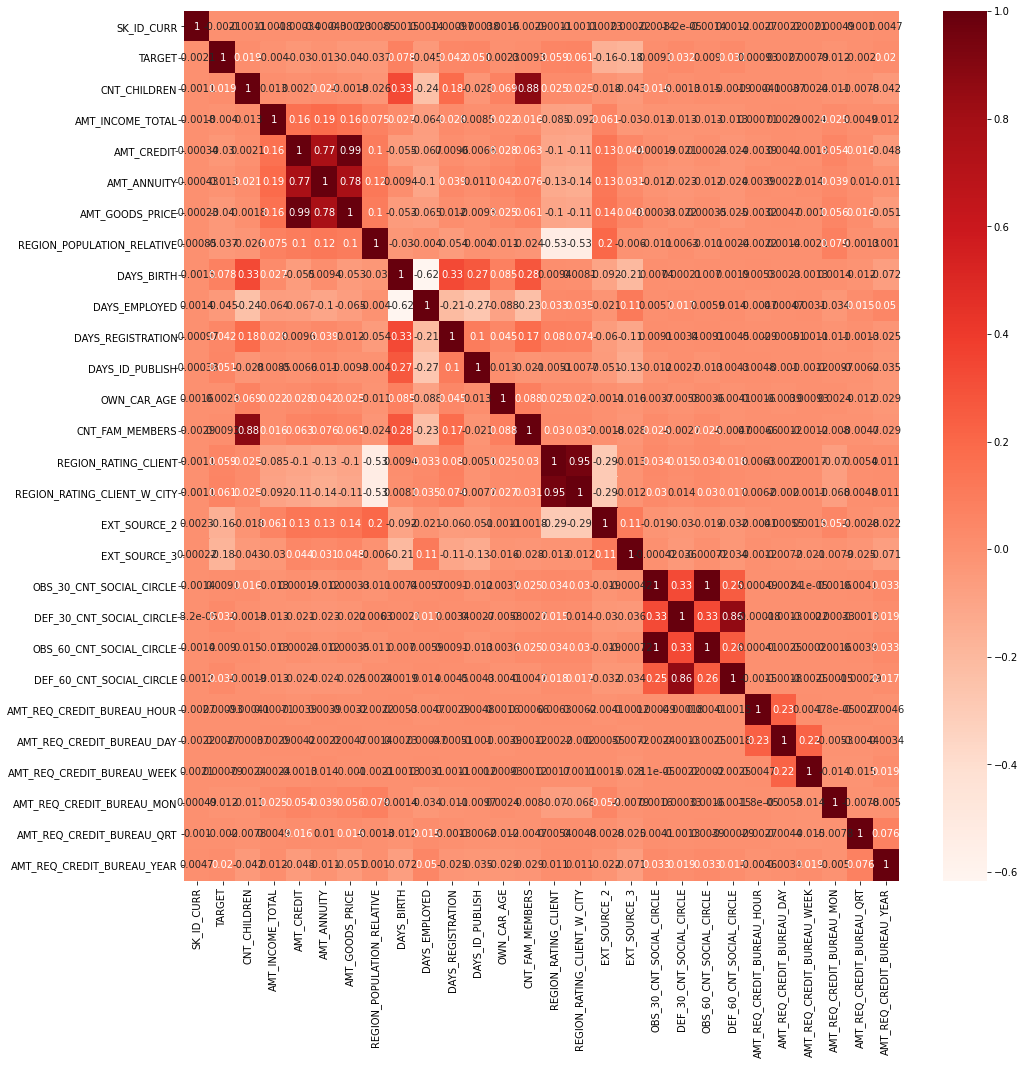

In [ ]:
# correlated features
#Using Pearson Correlation

plt.figure(figsize=(16,16))
corf = data.corr()
sns.heatmap(corf, annot=True, cmap=plt.cm.Reds)
plt.show()

In [ ]:
upperf = corf.where(np.triu(np.ones(corf.shape), k=1)
                          .astype(np.bool))

#print (upper)
to_dropf = [column for column in upperf
           .columns if any(upperf[column] > 0.9)]

print (to_dropf)
print (len(to_dropf))

['AMT_GOODS_PRICE', 'REGION_RATING_CLIENT_W_CITY', 'OBS_60_CNT_SOCIAL_CIRCLE']
3


In [ ]:
data['OCCUPATION_TYPE'].fillna('not work', inplace = True)
data['OWN_CAR_AGE'].fillna(0, inplace = True)

In [ ]:
missing_values = missing_values_table(data)
pd.set_option('display.max_rows', None)
print(missing_values)

Your selected dataframe has 86 columns.
There are 63 columns that have missing values.
                              Missing Values  % of Total Values
COMMONAREA_AVG                        214865               69.9
COMMONAREA_MODE                       214865               69.9
COMMONAREA_MEDI                       214865               69.9
NONLIVINGAPARTMENTS_MODE              213514               69.4
NONLIVINGAPARTMENTS_AVG               213514               69.4
NONLIVINGAPARTMENTS_MEDI              213514               69.4
FONDKAPREMONT_MODE                    210295               68.4
LIVINGAPARTMENTS_MODE                 210199               68.4
LIVINGAPARTMENTS_MEDI                 210199               68.4
LIVINGAPARTMENTS_AVG                  210199               68.4
FLOORSMIN_MEDI                        208642               67.8
FLOORSMIN_AVG                         208642               67.8
FLOORSMIN_MODE                        208642               67.8
YEARS_BUILD_AVG  

In [ ]:
for index, row in missing_values.iterrows():      # bỏ các cột có quá 45% giá trị NA
    if (row['% of Total Values'] > 45):
      data.drop(index, axis = 1, inplace=True)

In [ ]:
categorical_app_train = []
for col in data.columns:
    if data[col].dtype == 'object':
      categorical_app_train.append(col)
print(categorical_app_train)         # đếm các nhãn categorical

['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE']


In [ ]:
day_birth = (data['DAYS_BIRTH'] / -365)   # Kiểm tra thuộc tính tuổi
day_birth.describe()  

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

In [ ]:
data['DAYS_EMPLOYED'].describe()      # Kiểm tra thuộc tính số ngày làm việc

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

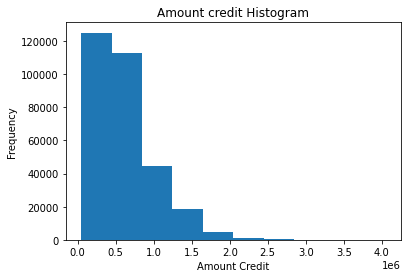

In [ ]:
data['AMT_CREDIT'].plot.hist(title = 'Amount credit Histogram');     
plt.xlabel('Amount Credit');

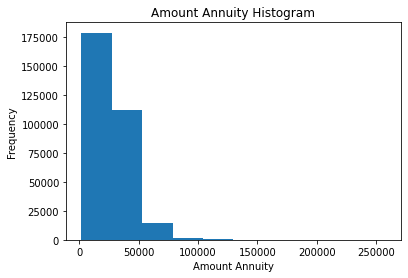

In [ ]:
data['AMT_ANNUITY'].plot.hist(title = 'Amount Annuity Histogram');     
plt.xlabel('Amount Annuity');

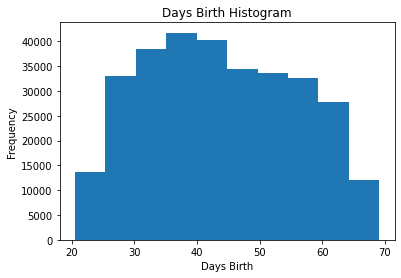

In [ ]:
day_birth.plot.hist(title = 'Days Birth Histogram');     
plt.xlabel('Days Birth');

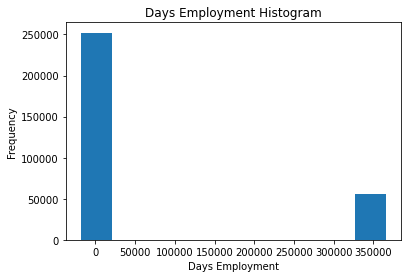

In [ ]:
data['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');     
plt.xlabel('Days Employment');

Có hơn 50000 thuộc tính có giá trị Days Employment bằng giá trị max = 365243 (thuộc tính bất thường) và gần 250000 có giá trị nhỏ hơn 0

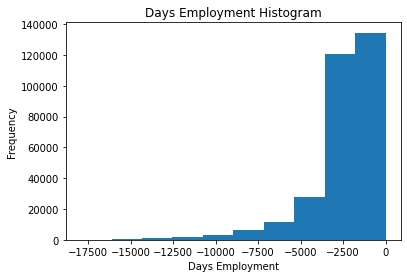

In [ ]:
# Create an anomalous flag column
# data['DAYS_EMPLOYED_ANOM'] = (data["DAYS_EMPLOYED"] == 365243)

# Replace the anomalous values with nan
data['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
data['DAYS_EMPLOYED'].fillna(data['DAYS_EMPLOYED'].mean(), inplace = True)


data['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [ ]:
# f = lambda x: x.mean() if np.issubdtype(x.dtype, np.number) else x.mode().iloc[0]
# data = data.fillna(data.groupby('TARGET').transform(f))

data1 = data[data['TARGET'] == 0]
data2 = data[data['TARGET'] == 1]

numeric1 = data1.select_dtypes('number')
numeric2 = data2.select_dtypes('number')

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

idf1 = pd.DataFrame(imputer.fit_transform(numeric1))
idf2 = pd.DataFrame(imputer.fit_transform(numeric2))

idf1.columns = numeric1.columns
idf1.index = numeric1.index
idf2.columns = numeric2.columns
idf2.index = numeric2.index

for col in idf1:
  data1.drop(col, axis=1, inplace=True)
  data1 = pd.concat([data1, idf1[col]], axis=1)

for col in idf2:
  data2.drop(col, axis=1, inplace=True)
  data2 = pd.concat([data2, idf2[col]], axis=1)

frames = [data1, data2]

data = pd.concat(frames)

print(data.shape)

In [ ]:
data.head(10)

In [ ]:
for col in data.columns:
    if data[col].dtype == 'object':
      print(col)

In [ ]:
#creating dummy variables
# for col in categorical_app_train:
#     dummies = pd.get_dummies(data[col])
#     data = pd.concat([data, dummies], axis=1)
#     data.drop(col, axis=1, inplace=True)
# data.head()
data = pd.get_dummies(data)
data.head()

In [ ]:
for col in data.columns:
  data[col].astype(float)
print(data.shape)

In [ ]:
data.head()

## 3.2 Table: bureau & Table bureau_balance

In [ ]:
# Read in new copies of all the dataframes
bureau = pd.read_csv('/content/drive/MyDrive/Credit Risk/Data/home_credit/bureau.csv')
# bureau_balance = pd.read_csv('/content/drive/MyDrive/Credit Risk/Data/home_credit/bureau_balance.csv')

In [ ]:
missing_values = missing_values_table(bureau)
pd.set_option('display.max_rows', None)
print(missing_values)

In [ ]:
bureau.drop(['AMT_ANNUITY', 'AMT_CREDIT_MAX_OVERDUE', 'SK_ID_BUREAU'], axis = 1, inplace=True)
bureau.fillna(0, inplace = True)

In [ ]:
# Groupby the client id (SK_ID_CURR), count the number of previous loans, and rename the column
# previous_loan_counts = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU': 'previous_loan_counts'})
# previous_loan_counts.head()

In [ ]:
# data = data.merge(previous_loan_counts, on = 'SK_ID_CURR', how = 'left')

# Fill the missing values with 0 
# data['previous_loan_counts'] = data['previous_loan_counts'].fillna(0)
# data.head()

In [ ]:
bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_counts.head()

In [ ]:
bureau_agg = agg_numeric(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_agg.head()


In [ ]:
# bureau_balance_counts = count_categorical(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
# bureau_balance_counts.head()

In [ ]:
# bureau_balance_agg = agg_numeric(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
# bureau_balance_agg.head()

In [ ]:
# # Dataframe grouped by the loan
# bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')

# # Merge to include the SK_ID_CURR
# bureau_by_loan = bureau[['SK_ID_BUREAU', 'SK_ID_CURR']].merge(bureau_by_loan, on = 'SK_ID_BUREAU', how = 'left')

# # Aggregate the stats for each client
# bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'client')

In [ ]:
# bureau_balance_by_client.head()

In [ ]:
# Merge with the value counts of bureau
data = data.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')

# Merge with the stats of bureau
data = data.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')

# Merge with the monthly information grouped by client
# data = data.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')

In [ ]:
new_features = list(data.columns)
print('Number of features using previous loans from other institutions data: ', len(new_features))

In [ ]:
missing_values = missing_values_table(data)
pd.set_option('display.max_rows', None)
print(missing_values)

In [ ]:
data.fillna(0, inplace = True)

In [ ]:
data.to_csv('/content/drive/MyDrive/Credit Risk/Data/appl+bureau_data.csv', index = False)

In [ ]:
data.head()

##3.3 Table previous_application

In [ ]:
del bureau, bureau_counts, bureau_agg

In [ ]:
previous = pd.read_csv('/content/drive/MyDrive/Credit Risk/Data/home_credit/previous_application.csv')
previous = previous[previous['NAME_CONTRACT_STATUS'] == 'Approved']
missing_values = missing_values_table(previous)
pd.set_option('display.max_rows', None)
print(missing_values)

In [ ]:
useless_columns = ['WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'FLAG_LAST_APPL_PER_CONTRACT',
                  'RATE_INTEREST_PRIMARY', 'RATE_INTEREST_PRIVILEGED', 'NAME_CONTRACT_STATUS',
                   'CODE_REJECT_REASON', 'NAME_TYPE_SUITE']
previous.drop(useless_columns, axis = 1, inplace=True)

In [ ]:
categorical = []
for col in previous.columns:
    if previous[col].dtype == 'object':
      categorical.append(col)
      print(col)

In [ ]:
previous.NFLAG_INSURED_ON_APPROVAL.value_counts()

In [ ]:
previous['AMT_DOWN_PAYMENT'].fillna(0, inplace = True)
previous['RATE_DOWN_PAYMENT'].fillna(0, inplace = True)
previous['NFLAG_INSURED_ON_APPROVAL'].fillna(0, inplace = True)

In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

In [ ]:
numeric_previous = previous.select_dtypes('number')
numeric_previous.head()

In [ ]:
idf = pd.DataFrame(imputer.fit_transform(numeric_previous))
idf.columns=numeric_previous.columns
idf.index=numeric_previous.index
idf.head()

In [ ]:
previous.head()

In [ ]:
for col in idf:
  previous.drop(col, axis=1, inplace=True)
  previous = pd.concat([previous, idf[col]], axis=1)

In [ ]:
missing_values = missing_values_table(previous)
pd.set_option('display.max_rows', None)
print(missing_values)

In [ ]:
for col in previous.columns:
    if previous[col].dtype == 'object':
      print(col)

In [ ]:
previous.drop(['SK_ID_PREV'], axis = 1, inplace = True)

In [ ]:
# Calculate aggregate statistics for each numeric column
previous_agg = agg_numeric(previous, 'SK_ID_CURR', 'previous')
previous_agg.head()

In [ ]:
# Calculate value counts for each categorical column
previous_counts = count_categorical(previous, 'SK_ID_CURR', 'previous')
previous_counts.head()

In [ ]:
# Merge in the previous information
data = data.merge(previous_counts, on ='SK_ID_CURR', how = 'left')
data = data.merge(previous_agg, on = 'SK_ID_CURR', how = 'left')

In [ ]:
missing_values = missing_values_table(data)
pd.set_option('display.max_rows', None)
print(missing_values)

In [ ]:
data.fillna(0, inplace = True)
del previous, previous_counts, previous_agg

##3.4 Table Monthly Cash Data

In [ ]:
cash = pd.read_csv('/content/drive/MyDrive/Credit Risk/Data/home_credit/POS_CASH_balance.csv')

In [ ]:
missing_values = missing_values_table(cash)
pd.set_option('display.max_rows', None)
print(missing_values)

In [ ]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
na_columns = cash[['CNT_INSTALMENT_FUTURE', 'CNT_INSTALMENT']]
na_columns.head()

In [ ]:
idf = pd.DataFrame(imputer.fit_transform(na_columns))
idf.columns=na_columns.columns
idf.index=na_columns.index
idf.head()

In [ ]:
for col in idf:
  cash.drop(col, axis=1, inplace=True)
  cash = pd.concat([cash, idf[col]], axis=1)
missing_values = missing_values_table(cash)
pd.set_option('display.max_rows', None)
print(missing_values)

In [ ]:
cash.drop(['SK_ID_PREV'], axis = 1, inplace = True)

In [ ]:
cash_agg = agg_numeric(cash, 'SK_ID_CURR', 'cash')
cash_counts = count_categorical(cash, 'SK_ID_CURR', 'cash')
data = data.merge(cash_agg, on ='SK_ID_CURR', how = 'left')
data = data.merge(cash_counts, on = 'SK_ID_CURR', how = 'left')

In [ ]:
# cash_by_client = aggregate_client(cash, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['cash', 'client'])
# cash_by_client.head()

In [ ]:
#data = data.merge(cash_by_client, on = 'SK_ID_CURR', how = 'left')
del cash, cash_agg, cash_counts
data.fillna(0, inplace = True)

##3.5 Table Monthly Credit Data & Installment Payments

In [ ]:
data.to_csv('/content/drive/MyDrive/Credit Risk/Data/processed_data_v01.csv', index=False)

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Credit Risk/Data/processed_data_v01.csv')

In [ ]:
print(data.shape)

In [ ]:
credit = pd.read_csv('/content/drive/MyDrive/Credit Risk/Data/home_credit/credit_card_balance.csv')

In [ ]:
missing_values = missing_values_table(credit)
print(missing_values)

In [ ]:
credit.drop(['SK_ID_PREV'], axis = 1, inplace = True)
credit.fillna(0, inplace = True)

In [ ]:
credit_agg = agg_numeric(credit, 'SK_ID_CURR', 'credit')
credit_counts = count_categorical(credit, 'SK_ID_CURR', 'credit')
data = data.merge(credit_agg, on ='SK_ID_CURR', how = 'left')
data = data.merge(credit_counts, on = 'SK_ID_CURR', how = 'left')

In [ ]:
#credit_by_client = aggregate_client(credit, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['credit', 'client'])

In [ ]:
#data = data.merge(credit_by_client, on = 'SK_ID_CURR', how = 'left')
del credit, credit_agg, credit_counts
data.fillna(0, inplace = True)

In [ ]:
data.head()

In [ ]:
print(data.shape)

In [ ]:
data.to_csv('/content/drive/MyDrive/Credit Risk/Data/processed_data_v02.csv', index=False)

In [ ]:
installments = pd.read_csv('/content/drive/MyDrive/Credit Risk/Data/home_credit/installments_payments.csv')
# installments.drop(['SK_ID_PREV'], axis = 1, inplace = True)
missing_values = missing_values_table(installments)
pd.set_option('display.max_rows', None)
print(missing_values)

Your selected dataframe has 8 columns.
There are 2 columns that have missing values.
                    Missing Values  % of Total Values
DAYS_ENTRY_PAYMENT            2905                0.0
AMT_PAYMENT                   2905                0.0


In [ ]:
# installments.drop(['NUM_INSTALMENT_VERSION', 'NUM_INSTALMENT_NUMBER'], axis = 1, inplace = True)
# installments.sort_values('SK_ID_CURR')
sort = installments.sort_values(by=['SK_ID_CURR'], ascending=True)
sort.head(10)

,SK_ID_PREV,SK_ID_CURR,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
3458712,1369693,100001,-1649.0,-1660.0,3951.000,3951.000
3435373,1851984,100001,-2856.0,-2856.0,3980.925,3980.925
2624024,1369693,100001,-1619.0,-1628.0,17397.900,17397.900
1761012,1851984,100001,-2916.0,-2916.0,3982.050,3982.050
3774071,1851984,100001,-2886.0,-2875.0,3982.050,3982.050
1478621,1369693,100001,-1709.0,-1715.0,3951.000,3951.000
2568722,1369693,100001,-1679.0,-1715.0,3951.000,3951.000
2163032,1038818,100002,-535.0,-562.0,9251.775,9251.775
504426,1038818,100002,-235.0,-250.0,9251.775,9251.775
699804,1038818,100002,-205.0,-224.0,9251.775,9251.775


In [ ]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
na_columns = installments[['DAYS_ENTRY_PAYMENT', 'AMT_PAYMENT']]
na_columns.head()
idf = pd.DataFrame(imputer.fit_transform(na_columns))
idf.columns=na_columns.columns
idf.index=na_columns.index
idf.head()
for col in idf:
  installments.drop(col, axis=1, inplace=True)
  installments = pd.concat([installments, idf[col]], axis=1)
missing_values = missing_values_table(installments)
pd.set_option('display.max_rows', None)
print(missing_values)

Your selected dataframe has 6 columns.
There are 0 columns that have missing values.
Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []


In [ ]:
# installments.drop(['SK_ID_PREV'], axis = 1, inplace = True)
installments_agg = agg_numeric(installments, 'SK_ID_CURR', 'installments')
installments_agg.head(10)

,SK_ID_CURR,installments_DAYS_INSTALMENT_mean,installments_DAYS_INSTALMENT_max,installments_DAYS_INSTALMENT_min,installments_DAYS_INSTALMENT_sum,installments_AMT_INSTALMENT_mean,installments_AMT_INSTALMENT_max,installments_AMT_INSTALMENT_min,installments_AMT_INSTALMENT_sum,installments_DAYS_ENTRY_PAYMENT_mean,installments_DAYS_ENTRY_PAYMENT_max,installments_DAYS_ENTRY_PAYMENT_min,installments_DAYS_ENTRY_PAYMENT_sum,installments_AMT_PAYMENT_mean,installments_AMT_PAYMENT_max,installments_AMT_PAYMENT_min,installments_AMT_PAYMENT_sum
0,100001,-2187.714286,-1619.0,-2916.0,-15314.0,5885.132143,17397.900,3951.000,41195.925,-2195.000000,-1628.0,-2916.0,-15365.0,5885.132143,17397.900,3951.000,41195.925
1,100002,-295.000000,-25.0,-565.0,-5605.0,11559.247105,53093.745,9251.775,219625.695,-315.421053,-49.0,-587.0,-5993.0,11559.247105,53093.745,9251.775,219625.695
2,100003,-1378.160000,-536.0,-2310.0,-34454.0,64754.586000,560835.360,6662.970,1618864.650,-1385.320000,-544.0,-2324.0,-34633.0,64754.586000,560835.360,6662.970,1618864.650
3,100004,-754.000000,-724.0,-784.0,-2262.0,7096.155000,10573.965,5357.250,21288.465,-761.666667,-727.0,-795.0,-2285.0,7096.155000,10573.965,5357.250,21288.465
4,100005,-586.000000,-466.0,-706.0,-5274.0,6240.205000,17656.245,4813.200,56161.845,-609.555556,-470.0,-736.0,-5486.0,6240.205000,17656.245,4813.200,56161.845
5,100006,-252.250000,-11.0,-545.0,-4036.0,62947.088438,691786.890,2482.920,1007153.415,-271.625000,-12.0,-575.0,-4346.0,62947.088438,691786.890,2482.920,1007153.415
6,100007,-1028.606061,-14.0,-2326.0,-67888.0,12666.444545,22678.785,1821.780,835985.340,-1032.242424,-14.0,-2318.0,-68128.0,12214.060227,22678.785,0.180,806127.975
7,100008,-1263.914286,-69.0,-2491.0,-44237.0,27702.964286,432218.295,8003.475,969603.750,-1237.800000,-82.0,-2519.0,-43323.0,27360.502714,432218.295,227.160,957617.595
8,100009,-855.823529,-43.0,-2908.0,-43647.0,9568.531765,17341.605,6155.280,487995.120,-864.411765,-58.0,-2914.0,-44085.0,9568.531765,17341.605,6155.280,487995.120
9,100010,-904.000000,-769.0,-1039.0,-9040.0,27449.208000,27463.410,27321.390,274492.080,-915.900000,-774.0,-1069.0,-9159.0,27449.208000,27463.410,27321.390,274492.080


In [ ]:
installments_agg = agg_numeric(installments, 'SK_ID_CURR', 'installments')
data = data.merge(installments_agg, on ='SK_ID_CURR', how = 'left')

In [ ]:
#print(installments_by_client.shape)

In [ ]:
#data = pd.read_csv('/content/drive/MyDrive/Credit Risk/Data/processed_data_v02.csv')

In [ ]:
#data = data.merge(installments_by_client, on = 'SK_ID_CURR', how = 'left')
del installments, installments_agg
data.fillna(0, inplace = True)
data.drop(['SK_ID_CURR'], axis = 1, inplace = True)

In [ ]:
data.to_csv('/content/drive/MyDrive/Credit Risk/Data/processed_data_final2.csv', index=False)

In [ ]:
print(data.shape)

#4. Model

## 4.1 ANN (Test accuracy: 74.13%)

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Credit Risk/Data/processed_data_final2.csv')
for col in data.columns:
    data[col].astype(float)
print(data.shape)
data.head()

data = data.sample(frac = 1)
data_label0 = data[(data['TARGET'] == 0)]
print(data_label0.shape)
data_label1 = data[(data['TARGET'] == 1)]
print(data_label1.shape)
data_label0 = data_label0.head(24825)
print(data_label0.shape)
Train = pd.concat([data_label0.head(17377), data_label1.head(17377) ], ignore_index=True)
Train = Train.sample(frac = 1)

val_test_label0 = data_label0.tail(7448)
val_test_label1 = data_label1.tail(7448)


Val = pd.concat([val_test_label0.head(3724), val_test_label1.head(3724) ], ignore_index=True)
Val = Val.sample(frac = 1)

Test = pd.concat([val_test_label0.tail(3724), val_test_label1.tail(3724) ], ignore_index=True)
Test = Test.sample(frac = 1)

Train.to_csv('/content/drive/MyDrive/Credit Risk/Data/train_data.csv', index=False)
Val.to_csv('/content/drive/MyDrive/Credit Risk/Data/validation_data.csv', index=False)
Test.to_csv('/content/drive/MyDrive/Credit Risk/Data/test_data.csv', index=False)

(307511, 715)
(282686, 715)
(24825, 715)
(24825, 715)


In [ ]:
Train = pd.read_csv('/content/drive/MyDrive/Credit Risk/Data/train_data.csv')
Val = pd.read_csv('/content/drive/MyDrive/Credit Risk/Data/validation_data.csv')
Test = pd.read_csv('/content/drive/MyDrive/Credit Risk/Data/test_data.csv')

X_train = Train.drop('TARGET', axis = 1)
X_test = Test.drop('TARGET', axis = 1)
X_val = Val.drop('TARGET', axis = 1)

y_train = Train.TARGET
y_test = Test.TARGET
y_val = Val.TARGET

y_train=np.ravel(y_train)
y_test=np.ravel(y_test)
y_val = np.ravel(y_val)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

scaler = StandardScaler().fit(X_val)
X_val = scaler.transform(X_val)

scaler = StandardScaler().fit(X_test)
X_test = scaler.transform(X_test)  


Grid Search giá trị khởi tạo trọng số ban đầu, tốc độ học và momentum

In [ ]:
def create_model(init_mode='uniform'):
	# create model
  input_nodes = X_train.shape[1]
  model = Sequential()
  model.add(Dense(20, activation='relu', kernel_initializer=init_mode, input_shape=(input_nodes,)))
  model.add(Dense(10, activation='relu', kernel_initializer=init_mode))
  model.add(Dense(1, activation='sigmoid', kernel_initializer=init_mode))

	# Compile model
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model
# fix random seed for reproducibility

seed = 7
numpy.random.seed(seed)

model = KerasClassifier(build_fn=create_model, epochs=30, batch_size=10, verbose=0)
# define the grid search parameters
init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
param_grid = dict(init_mode=init_mode)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best: 0.714099 using {'init_mode': 'normal'}
0.710423 (0.001995) with: {'init_mode': 'uniform'}
0.699773 (0.002038) with: {'init_mode': 'lecun_uniform'}
0.714099 (0.001049) with: {'init_mode': 'normal'}
0.498640 (0.000908) with: {'init_mode': 'zero'}
0.697457 (0.004039) with: {'init_mode': 'glorot_normal'}
0.697558 (0.002914) with: {'init_mode': 'glorot_uniform'}
0.691314 (0.002525) with: {'init_mode': 'he_normal'}
0.696400 (0.004091) with: {'init_mode': 'he_uniform'}


In [ ]:
# Use scikit-learn to grid search the learning rate and momentum
# Function to create model, required for KerasClassifier
def create_model(learn_rate=0.01, momentum=0):
	# create model
  input_nodes = X_train.shape[1]
  model = Sequential()
  model.add(Dense(20, activation='relu', input_shape=(input_nodes,)))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
	# Compile model
  optimizer = SGD(lr=learn_rate, momentum=momentum)
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  return model
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# load dataset
# create model
model = KerasClassifier(build_fn=create_model, epochs=30, batch_size=10, verbose=0)
# define the grid search parameters
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.005]
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
param_grid = dict(learn_rate=learn_rate, momentum=momentum)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Best: 0.710826 using {'learn_rate': 0.005, 'momentum': 0.9}
0.701586 (0.006427) with: {'learn_rate': 0.001, 'momentum': 0.0}
0.703197 (0.007953) with: {'learn_rate': 0.001, 'momentum': 0.2}
0.699345 (0.005558) with: {'learn_rate': 0.001, 'momentum': 0.4}
0.703676 (0.003705) with: {'learn_rate': 0.001, 'momentum': 0.6}
0.699899 (0.007484) with: {'learn_rate': 0.001, 'momentum': 0.8}
0.692397 (0.003560) with: {'learn_rate': 0.001, 'momentum': 0.9}
0.696702 (0.004208) with: {'learn_rate': 0.01, 'momentum': 0.0}
0.700000 (0.003543) with: {'learn_rate': 0.01, 'momentum': 0.2}
0.696878 (0.001772) with: {'learn_rate': 0.01, 'momentum': 0.4}
0.700579 (0.006315) with: {'learn_rate': 0.01, 'momentum': 0.6}
0.707075 (0.002588) with: {'learn_rate': 0.01, 'momentum': 0.8}
0.704456 (0.001497) with: {'learn_rate': 0.01, 'momentum': 0.9}
0.700957 (0.005102) with: {'learn_rate': 0.1, 'momentum': 0.0}
0.691138 (0.001040) with: {'learn_rate': 0.1, 'momentum': 0.2}
0.677442 (0.001379) with: {'learn_rate':

Tối ưu số lượng neuron trong tầng ẩn trên tập validation_data

In [ ]:
import sys

space = {
            'units1': hp.uniform('units1', 10,100),
            'units2': hp.uniform('units2', 10,100),
        }

def f_nn(params):   
    print ('Params testing: ', params)
    mc = ModelCheckpoint('bestmodel.h5', monitor='val_accuracy', verbose=1, mode='max', save_best_only=True)
    model = Sequential()
    model.add(Dense(params['units1'], activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dense(params['units1'], activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.fit(X_train, y_train, epochs=22, batch_size=1 , verbose = 0, validation_data=(X_val, y_val), callbacks=[mc])
    saved_model = load_model('bestmodel.h5')
    pred_auc =saved_model.predict_classes(X_val)
    acc = accuracy_score(y_val, pred_auc)
    print('accuracy:', acc)
    sys.stdout.flush() 
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f_nn, space, algo=tpe.suggest, max_evals=30, trials=trials)
print("ANN: Hyperopt estimated optimum : ")
print(best)

Params testing: 
{'units1': 41.5073064003261, 'units2': 72.8438254623629}

Epoch 00001: val_accuracy improved from -inf to 0.70059, saving model to bestmodel.h5

Epoch 00002: val_accuracy improved from 0.70059 to 0.70140, saving model to bestmodel.h5

Epoch 00003: val_accuracy improved from 0.70140 to 0.70663, saving model to bestmodel.h5

Epoch 00004: val_accuracy improved from 0.70663 to 0.71066, saving model to bestmodel.h5

Epoch 00005: val_accuracy improved from 0.71066 to 0.72449, saving model to bestmodel.h5

Epoch 00006: val_accuracy improved from 0.72449 to 0.73147, saving model to bestmodel.h5

Epoch 00007: val_accuracy did not improve from 0.73147

Epoch 00008: val_accuracy improved from 0.73147 to 0.73496, saving model to bestmodel.h5

Epoch 00009: val_accuracy did not improve from 0.73496

Epoch 00010: val_accuracy did not improve from 0.73496

Epoch 00011: val_accuracy improved from 0.73496 to 0.73577, saving model to bestmodel.h5

Epoch 00012: val_accuracy did not improv

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '



accuracy:
0.7357679914070892
Params testing: 
{'units1': 50.93071299194142, 'units2': 79.03058982934245}

Epoch 00001: val_accuracy improved from -inf to 0.70234, saving model to bestmodel.h5

Epoch 00002: val_accuracy did not improve from 0.70234

Epoch 00003: val_accuracy improved from 0.70234 to 0.70260, saving model to bestmodel.h5

Epoch 00004: val_accuracy improved from 0.70260 to 0.72248, saving model to bestmodel.h5

Epoch 00005: val_accuracy improved from 0.72248 to 0.73255, saving model to bestmodel.h5

Epoch 00006: val_accuracy did not improve from 0.73255

Epoch 00007: val_accuracy improved from 0.73255 to 0.73281, saving model to bestmodel.h5

Epoch 00008: val_accuracy improved from 0.73281 to 0.73429, saving model to bestmodel.h5

Epoch 00009: val_accuracy did not improve from 0.73429

Epoch 00010: val_accuracy did not improve from 0.73429

Epoch 00011: val_accuracy did not improve from 0.73429

Epoch 00012: val_accuracy did not improve from 0.73429

Epoch 00013: val_accu

In [ ]:
Train = pd.read_csv('/content/drive/MyDrive/Credit Risk/Data/train_data.csv')
Val = pd.read_csv('/content/drive/MyDrive/Credit Risk/Data/validation_data.csv')
Test = pd.read_csv('/content/drive/MyDrive/Credit Risk/Data/test_data.csv')

X_train = Train.drop('TARGET', axis = 1)
X_test = Test.drop('TARGET', axis = 1)
X_val = Val.drop('TARGET', axis = 1)

y_train = Train.TARGET
y_test = Test.TARGET
y_val = Val.TARGET

y_train=np.ravel(y_train)
y_test=np.ravel(y_test)
y_val = np.ravel(y_val)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

scaler = StandardScaler().fit(X_val)
X_val = scaler.transform(X_val)

scaler = StandardScaler().fit(X_test)
X_test = scaler.transform(X_test)  

Huấn luyện với hyperparameter đã chọn

In [ ]:
mc = ModelCheckpoint('model.h5', monitor='val_accuracy', verbose=1, mode='max', save_best_only=True)
model = Sequential()
model.add(Dense(17, activation='relu',input_shape=(X_train.shape[1],)))
model.add(Dense(93, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=50, batch_size=1, verbose = 0, validation_data=(X_val, y_val), callbacks=[mc])



Epoch 00001: val_accuracy improved from -inf to 0.69441, saving model to model.h5

Epoch 00002: val_accuracy improved from 0.69441 to 0.70328, saving model to model.h5

Epoch 00003: val_accuracy improved from 0.70328 to 0.70583, saving model to model.h5

Epoch 00004: val_accuracy improved from 0.70583 to 0.71643, saving model to model.h5

Epoch 00005: val_accuracy improved from 0.71643 to 0.72113, saving model to model.h5

Epoch 00006: val_accuracy improved from 0.72113 to 0.73255, saving model to model.h5

Epoch 00007: val_accuracy improved from 0.73255 to 0.73523, saving model to model.h5

Epoch 00008: val_accuracy improved from 0.73523 to 0.73765, saving model to model.h5

Epoch 00009: val_accuracy improved from 0.73765 to 0.74141, saving model to model.h5

Epoch 00010: val_accuracy did not improve from 0.74141

Epoch 00011: val_accuracy improved from 0.74141 to 0.74181, saving model to model.h5

Epoch 00012: val_accuracy did not improve from 0.74181

Epoch 00013: val_accuracy did 

Accuracy đạt giá trị cao nhất là 0.74181 trên tập validation tại lần lặp thứ 11

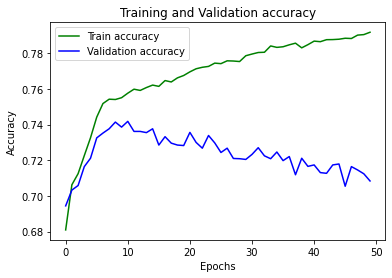

In [ ]:
acc_train = history.history['accuracy']
acc_test = history.history['val_accuracy']
plt.plot(acc_train, 'g', label='Train accuracy')
plt.plot(acc_test, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Kiểm tra độ chính xác trên tập test

In [ ]:
# from keras.models import load_model
saved_model = load_model('model.h5')
training_preds = (saved_model.predict(X_train) > 0.5).astype("int32")
y_pred = (saved_model.predict(X_test) > 0.5).astype("int32")
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, y_pred)
print("Training accuracy: %f" %(training_accuracy))
print("Testing accuracy: %f" %(test_accuracy))

Training accuracy: 0.764459
Testing accuracy: 0.733485


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.72      0.76      0.74      3724
         1.0       0.75      0.71      0.73      3724

    accuracy                           0.73      7448
   macro avg       0.73      0.73      0.73      7448
weighted avg       0.73      0.73      0.73      7448



Confusion matrix, without normalization
[[2829  895]
 [1090 2634]]


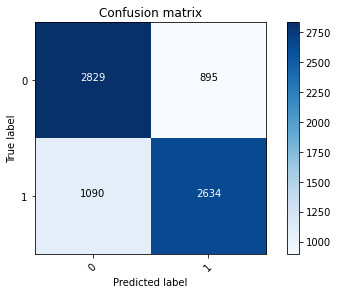

In [ ]:
cnf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cnf_matrix, classes=[0,1])

In [ ]:
saved_model.save('/content/drive/MyDrive/Nhóm 25/Model/ANN_model.h5')


##4.2 XG Boost (Accuracy test 77,28 %)

In [ ]:
Train = pd.read_csv('/content/drive/MyDrive/Nhóm 25/Data/train_data.csv')
Train.rename(columns = lambda x: x.replace(' ', '_'), inplace=True)
Val = pd.read_csv('/content/drive/MyDrive/Nhóm 25/Data/validation_data.csv')
Val.rename(columns = lambda x: x.replace(' ', '_'), inplace=True)
Test = pd.read_csv('/content/drive/MyDrive/Nhóm 25/Data/test_data.csv')
Test.rename(columns = lambda x: x.replace(' ', '_'), inplace=True)

X_train = Train.drop('TARGET', axis = 1)
X_test = Test.drop('TARGET', axis = 1)
X_val = Val.drop('TARGET', axis = 1)

y_train = Train.TARGET
y_test = Test.TARGET
y_val = Val.TARGET

y_train = list(y_train)
y_test=list(y_test)
y_val = list(y_val)

model = xgb.XGBClassifier(learning_rate =0.01, n_estimators=10000, max_depth=6)
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, early_stopping_rounds=300, eval_metric="error", eval_set=eval_set, verbose=True)

dump(model, "XGB_model.dat")
training_preds = model.predict(X_train)
y_pred = model.predict(X_val)
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_val, y_pred)

[0]	validation_0-error:0.25433	validation_1-error:0.267723
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 300 rounds.
[1]	validation_0-error:0.25433	validation_1-error:0.267723
[2]	validation_0-error:0.254273	validation_1-error:0.267857
[3]	validation_0-error:0.254359	validation_1-error:0.267857
[4]	validation_0-error:0.254273	validation_1-error:0.267857
[5]	validation_0-error:0.254273	validation_1-error:0.267857
[6]	validation_0-error:0.254417	validation_1-error:0.267991
[7]	validation_0-error:0.254273	validation_1-error:0.267857
[8]	validation_0-error:0.253467	validation_1-error:0.267723
[9]	validation_0-error:0.253554	validation_1-error:0.267723
[10]	validation_0-error:0.252057	validation_1-error:0.266246
[11]	validation_0-error:0.249755	validation_1-error:0.263963
[12]	validation_0-error:0.249583	validation_1-error:0.264098
[13]	validation_0-error:0.250072	validation_1-error:0.263

Tập validation thu được giá trị lỗi nhõ nhất là 0.2276 tại vòng tại vòng lặp thứ 1154

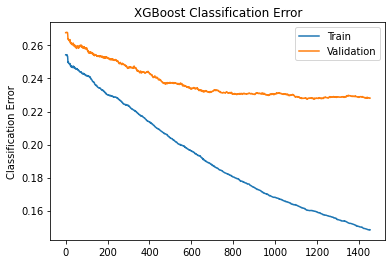

In [ ]:
results = model.evals_result()
epochs = len(results['validation_0']['error'])

x_axis = range(0, epochs)
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Validation')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

In [ ]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.77      0.79      0.78      3724
         1.0       0.78      0.76      0.77      3724

    accuracy                           0.77      7448
   macro avg       0.77      0.77      0.77      7448
weighted avg       0.77      0.77      0.77      7448



Confusion matrix, without normalization
[[2924  800]
 [ 895 2829]]


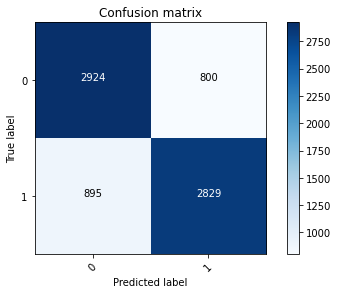

In [ ]:
cnf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cnf_matrix, classes=[0,1])

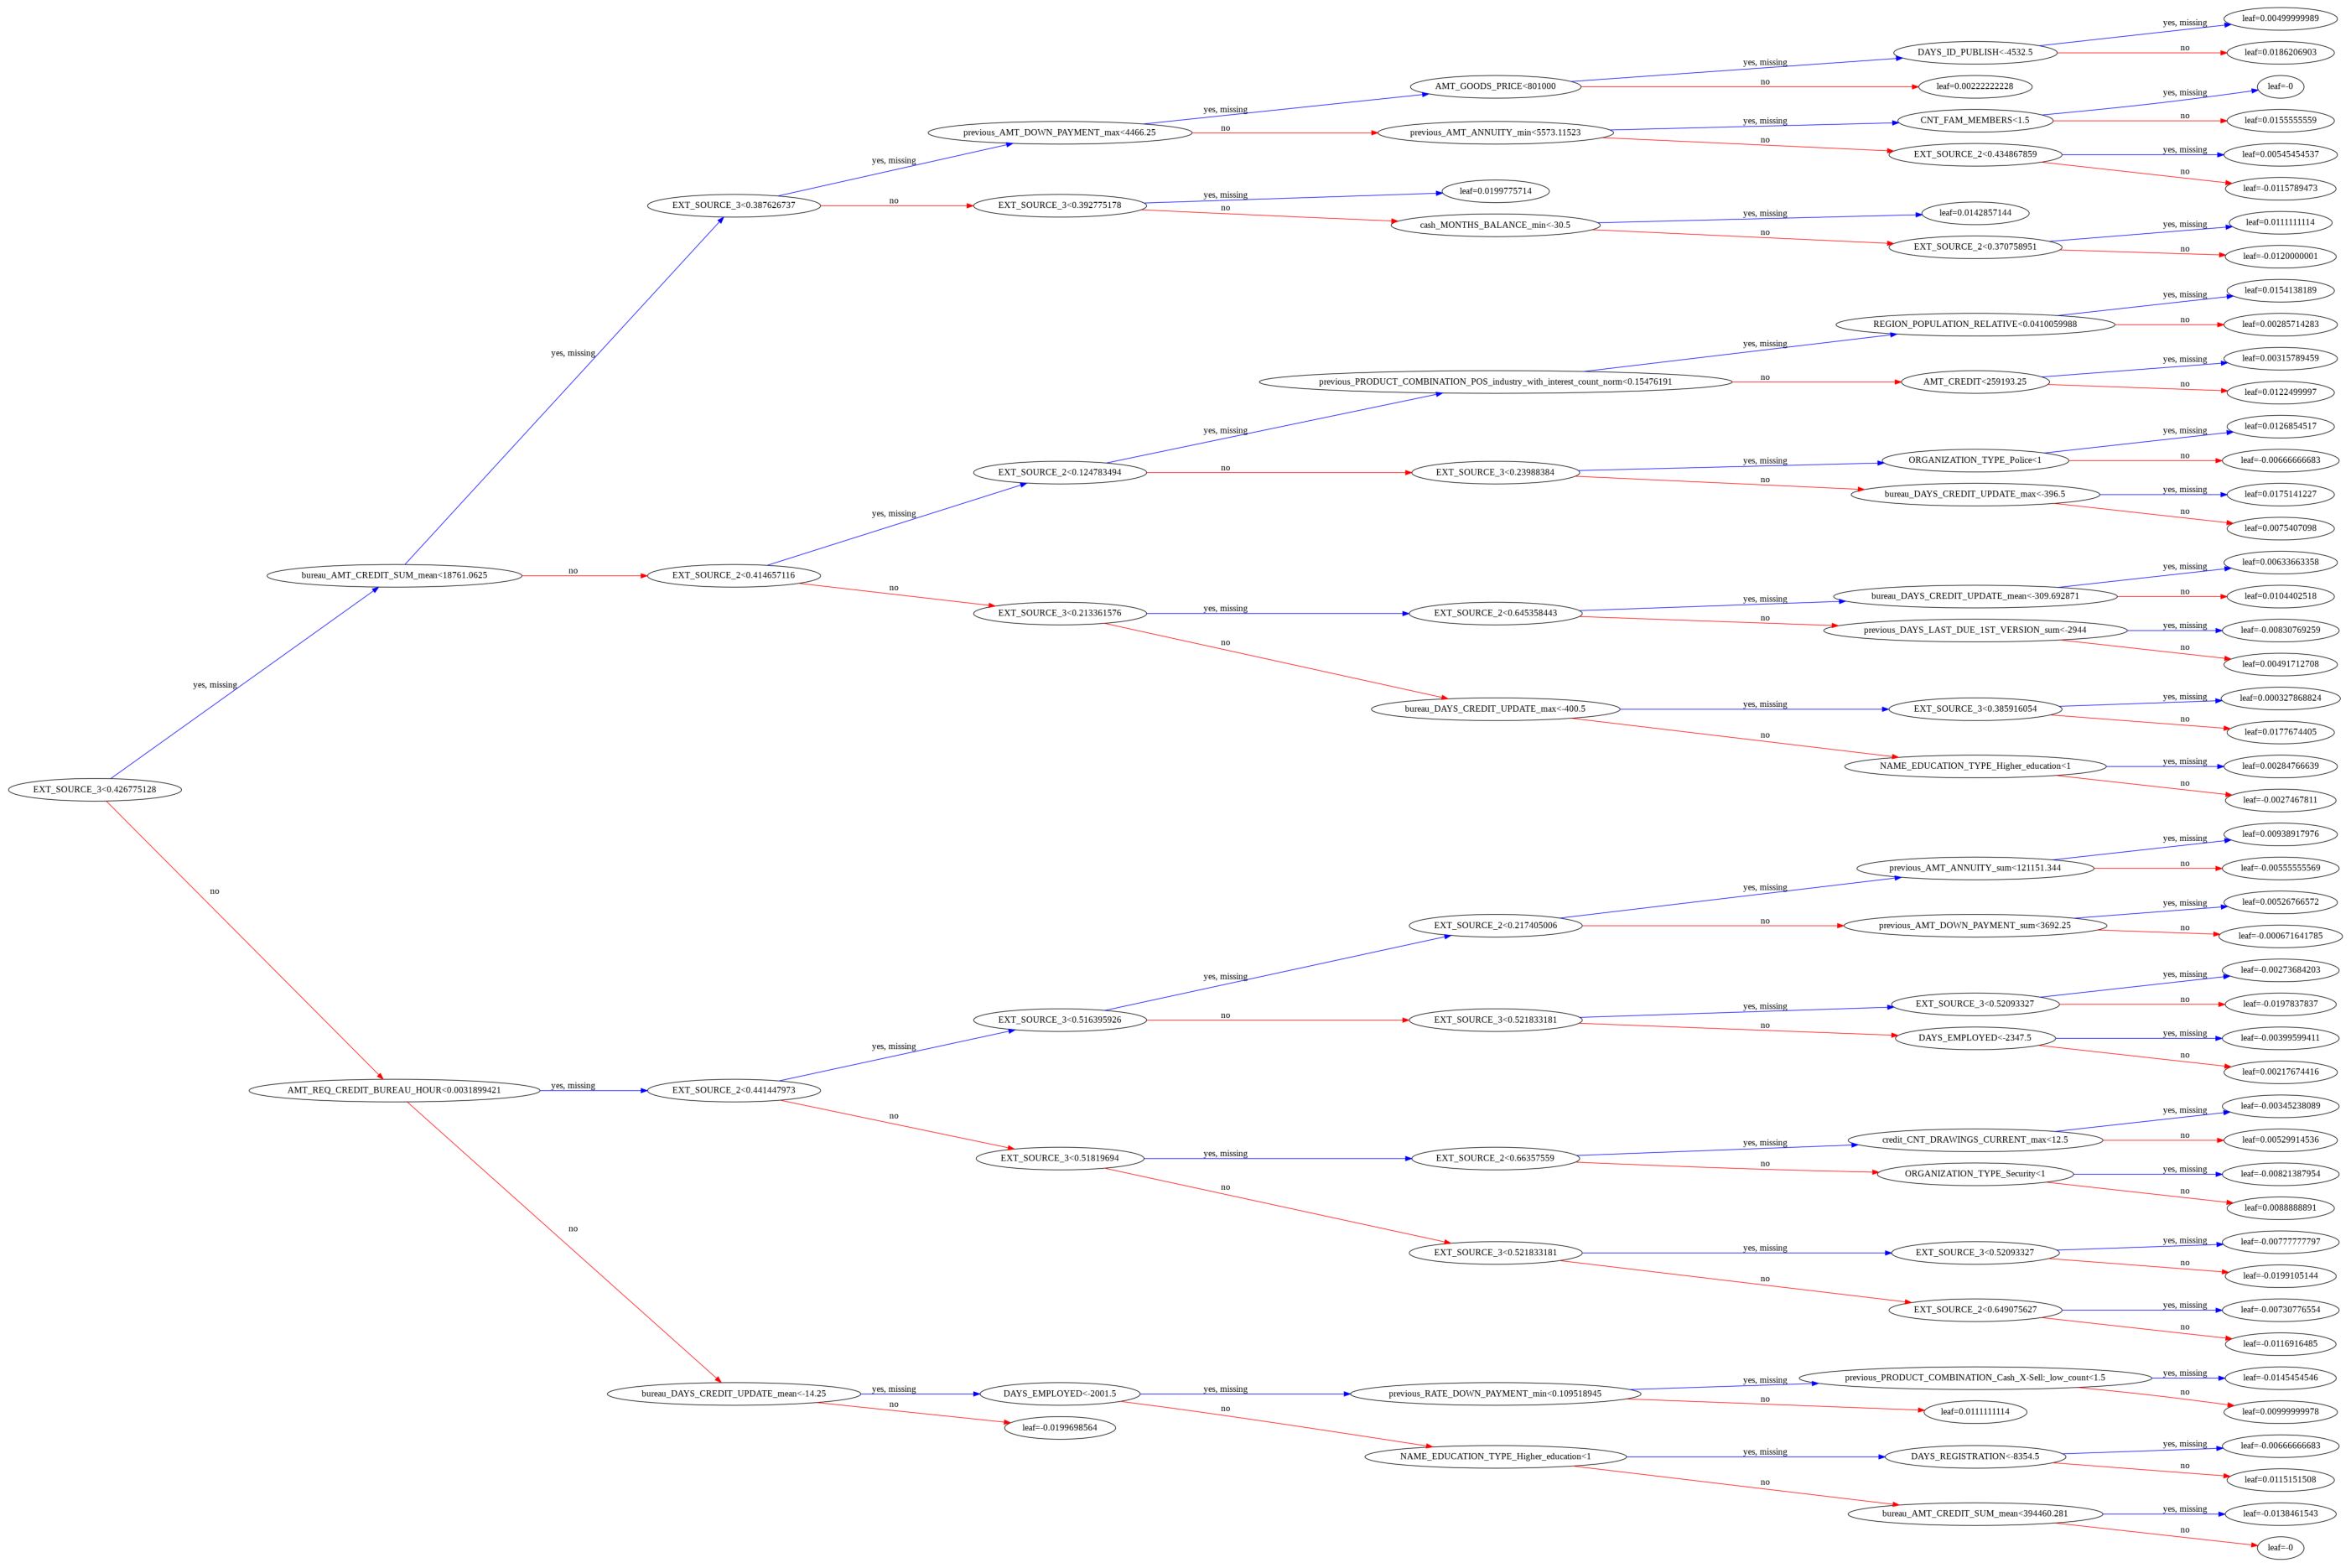

In [ ]:
from xgboost import plot_tree
# plot_tree(model, rankdir='LR')
# pyplot.show()

fig, ax = pyplot.subplots(figsize=(50, 50))
plot_tree(model, ax=ax,  rankdir='LR')
pyplot.show()

['bureau_CREDIT_TYPE_Microloan_count', 'cash_SK_DPD_mean', 'AMT_REQ_CREDIT_BUREAU_QRT', 'REGION_RATING_CLIENT_W_CITY', 'OCCUPATION_TYPE_Laborers', 'previous_NAME_PRODUCT_TYPE_walk-in_count_norm', 'cash_CNT_INSTALMENT_FUTURE_mean', 'previous_PRODUCT_COMBINATION_POS industry without interest_count', 'previous_AMT_DOWN_PAYMENT_max', 'AMT_GOODS_PRICE', 'NAME_INCOME_TYPE_Working', 'credit_AMT_RECIVABLE_mean', 'credit_AMT_DRAWINGS_CURRENT_mean', 'NAME_CONTRACT_TYPE_Cash loans', 'previous_NAME_PORTFOLIO_POS_count', 'previous_CNT_PAYMENT_max', 'bureau_CREDIT_TYPE_Consumer credit_count', 'previous_NAME_YIELD_GROUP_high_count_norm', 'FLAG_OWN_CAR_N', 'credit_CNT_DRAWINGS_CURRENT_mean', 'previous_NAME_CLIENT_TYPE_New_count_norm', 'cash_CNT_INSTALMENT_FUTURE_max', 'bureau_DAYS_CREDIT_max', 'credit_CNT_DRAWINGS_ATM_CURRENT_mean', 'CODE_GENDER_F', 'NAME_EDUCATION_TYPE_Higher education', 'EXT_SOURCE_2', 'bureau_AMT_CREDIT_SUM_mean', 'AMT_REQ_CREDIT_BUREAU_DAY', 'EXT_SOURCE_3']
[0.0035327626, 0.003583

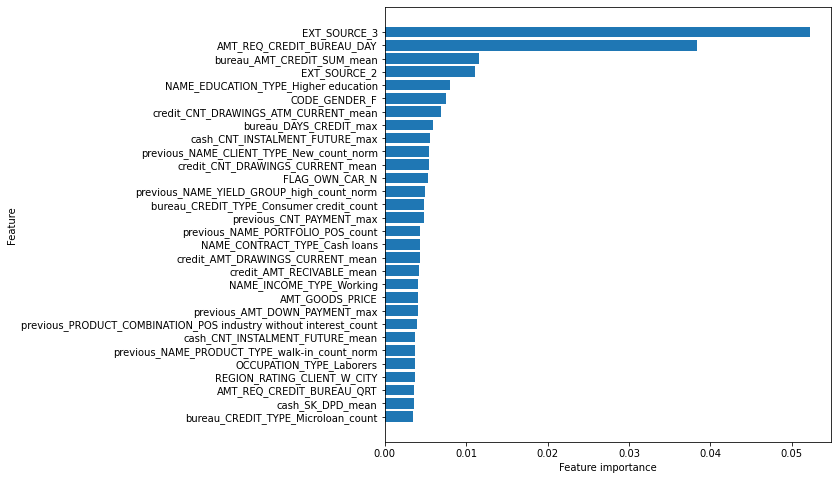

In [ ]:
plot_feature_importances(model,X_train)           # 30 thuộc tính quan trọng nhất

# Test

In [ ]:
loaded_model = load("/content/drive/MyDrive/Credit Risk/Model/XGB_model.dat")
loaded_model = keras.models.load_model("/content/drive/MyDrive/Credit Risk/Model/ANN_model.h5")
data = pd.read_csv('/content/drive/MyDrive/Credit Risk/Data/test_data.csv')
X_test = data.drop('TARGET', axis = 1)
y_test = data.TARGET
predictions = loaded_model.predict_proba(X_test)
prediction2 = []
for item in predictions:
  prediction2.append(item[0])
i = 1
customer = []
for item in prediction2:
  customer.append("customer " + str(i))
  i += 1
predict = pd.DataFrame(prediction2, columns=['Probability paid off'])
customer = pd.DataFrame(customer, columns=['Customer'])
predict = pd.concat([customer,predict], axis = 1)
predict.head()

,Customer,Probability paid off
0,customer 1,0.099406
1,customer 2,0.143282
2,customer 3,0.784364
3,customer 4,0.752355
4,customer 5,0.129687
